# Juggling RL project

## Install dependencies

It is also necessary to have ffmpeg software installed, in particular its bin folder in your path : <br>

On Windows : tuto - https://www.wikihow.com/Install-FFmpeg-on-Windows <br>
download - https://www.gyan.dev/ffmpeg/builds/


In [1]:
#!pip install gymnasium
#!pip install keras-rl2
#!pip install mediapy
#!pip install mujoco

## Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import gymnasium as gym
from gymnasium import spaces

## Import model

""

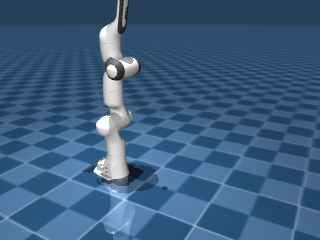

In [2]:
# Make model and data -- https://mujoco.readthedocs.io/en/stable/python.html
model = mujoco.MjModel.from_xml_path("./robot/scene.xml") #
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [32]:
duration = 4  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
data.ctrl[1]=-0.476
data.ctrl[2]=-2.14
while data.time < duration: #data.time in second (float)
  if int(data.time*1000) % 1000 == 0: print(data.time)
  if int(data.time*1000) % 100 == 0: print(data.xpos[8])
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render().copy()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

0.0
[0. 0. 0.]
[0.33   0.     1.4902]
[0.33   0.     1.4604]
[0.33   0.     1.4106]
[0.33   0.     1.3408]
[0.33  0.    1.251]
[0.33   0.     1.1412]
[0.33   0.     1.0114]
[0.33   0.     0.8616]
[ 0.32579703 -0.00182703  0.73626799]
1.0000000000000007
[ 0.32289378 -0.00159325  0.73797557]
[ 0.3226356  -0.00188957  0.73937868]
[ 0.3226801  -0.00227866  0.74055831]
[ 0.32278211 -0.00266296  0.74169693]
[ 0.32288639 -0.00291392  0.74274299]
[ 0.32298983 -0.00308739  0.74371014]
[ 0.32326788 -0.00320756  0.74458496]
[ 0.32362534 -0.00325757  0.74528129]
[ 0.32389317 -0.00328154  0.74576299]
[ 0.32407923 -0.00329746  0.74608347]
2.0000000000000013
[ 0.32420503 -0.00330423  0.74629476]


## Monte Carlo method

In [33]:
# inspect allows you to get all the method of a class 
# - useful to understand a library with little documentation
# import inspect
# inspect.getmembers(data, predicate=inspect.ismethod)

# We found out that the position are given among others by data.xpos
# It is a list of list for each body with x, y and z position
# Position of the ball in our model : data.xpos[-1] = data.xpos[8]
# It is probably because we loaded the ball after the juggler in scene.xml

In [5]:
# Format of a trajectory (dur_cycle, ((t1, x1, y1, z1), ..., (tn, xn, yn, zn)))
# Format of a command (dur_cycle, ((t1, act2-1, act3-1), ..., (tn, act2-n, act3-n)))
# command[0] = 0 if not a cycle
# command[0] > 0 if it is a cycle (then dur_cycle > tn)

def trajectory_to_command(trajectory): # Error if out of range
    pass

def update_arm(command, current_time, command_step):
    #print(round(current_time, 3))
    if (int(round(current_time * 1000)) % int(round(command[0]*1000)) == 
        int(round(command[1][command_step][0]*1000))):
        data.ctrl[1] = command[1][command_step][1]
        data.ctrl[2] = command[1][command_step][2]
        command_step = (command_step + 1) % len(command[1])
        print(command_step)
    #print("in function", command_step)
    return command_step

In [6]:
duration = 7  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
def simulation_video(command):
  frames = []
  mujoco.mj_resetData(model, data)  # Reset state and time.
  command_step = 0
  while data.time < duration: #data.time in second (float)
    #if abs(round(data.time) - data.time) < 0.005: print(data.time)
    if int(round(data.time * 1000)) % 1000 == 0: print(f"Computed {int(round(data.time))} out of {duration} seconds")
    command_step = update_arm(command, data.time, command_step)
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data)
      pixels = renderer.render().copy()
      frames.append(pixels)
    #print(command_step)
  return frames

In [14]:
command = (4, ((0, -0.476, -2.14), (1, -0.2, -1.8), (2, 1, -1.8),
               (3, 0.2, -1.5)))
media.show_video(simulation_video(command), fps=framerate)

Computed 0 out of 7 seconds
1
Computed 1 out of 7 seconds
2
Computed 2 out of 7 seconds
3
Computed 3 out of 7 seconds
0
Computed 4 out of 7 seconds
1
Computed 5 out of 7 seconds
2
Computed 6 out of 7 seconds
3
Computed 7 out of 7 seconds
0


In [ ]:
# Global Variables

PROBA_DUPLICATED = 0.1
PROBA_REMOVED = 0.1
CYCLE_DURATION_SD = 1 #second

TIME_SD = 0.1 #second
ACT2_SD = 0.1 #radiant
ACT3_SD = 0.1 #radiant

THRESHOLD = 1 #meter

In [ ]:
class Monte_Carlo_scene():
    def __init__(self, proba_duplicated, proba_removed, cycle_duration_sd,
                time_sd, act2_sd, act3_sd, THRESHOLD):
        self.proba_duplicated = proba_duplicated
        self.proba_removed = proba_removed
        self.cycle_duration_sd = cycle_duration_sd
        
        self.time_sd = time_sd
        self.act2_sd = act2_sd
        self.act3_sd = act3_sd
        self.threshold = threshold

    def learning(self, expert_command, nb_episodes=5, nb_roll_outs=20): 
        """
        Description : Global function with the loop over episodes
        Input :
        - Look above
        Output :
        - The last high policy
        - The best policy of each episode
        """
        high_policy = expert_command

        best_results = []
        for id_episode in range(nb_episodes):

            results, best_result = self.episode(high_policy, nb_roll_outs)
            best_results.append(best_results)
            self.compute_high_policy(results)

        return high_policy, best_results
            

    def episode(self, high_policy, nb_roll_outs): 
        """
        Loop over roll_outs
        Output:
        - All the commands of the roll-outs with associated rewards
        - The best command of the episode with associated reward
        """
        results = []
        best_result = [[], -1]
        for id_roll_out in range(nb_roll_outs):
            command = self.sample_policy(high_policy)
            ball_positions, command = self.roll_out(command)
            roll_out_reward = self.reward(ball_positions)
            if roll_out_reward>best_result[1]:
                best_result = [command, roll_out_reward]
            results.append([command, roll_out_reward])
        return results, best_result


    def roll_out(self, command): 
        """
        Get a deterministic policy from the stochastic policy of the episode
        Input:
        - A command
        Output:
        - The ball positions at each steps
        - The command
        """
        pass

    def reward(self, ball_pos_list): 
        """
        From the list of the ball positions returned by a roll_out, returns the reward
        """
        count_juggling = 0
        below_before = True
        for ball_pos in ball_pos_list:
            if below_before and ball_pos[2] > self.threshold:
                count_juggling += 1
                below_before = False
            if not below_before and ball_pos[2] < self.threshold:
                below_before = True
        
        return count_juggling


    def compute_high_policy(self, results): 
        # For the moment the length of a command is a hyperparameter
        """
        Merge the roll_out policies using a weighted sum depending 
        on the number of catches (in episode != 0)
        Input:
        - 
        """
        nb_step = len(results[0][0][1])
        high_policy = [0, [[0, 0, 0] for i in range(nb_step)]]
        sum_reward = 0
        for result in results: # result = [command, reward]
            sum_reward += result[1]
            high_policy[0] += result[0][0] * result[1]
            for step in range(nb_step):
                high_policy[1][step][0] += result[0][1][step][0] * result[1]
                high_policy[1][step][1] += result[0][1][step][1] * result[1]
                high_policy[1][step][2] += result[0][1][step][2] * result[1]
        #normalisation
        high_policy[1] /= sum_reward
        high_policy[1][step][0] /= sum_reward
        high_policy[1][step][1] /= sum_reward
        high_policy[1][step][2] /= sum_reward

        return high_policy


    def sample_policy(self, high_policy):
        # Format of a command (dur_cycle, ((t1, act2-1, act3-1), ..., (tn, act2-n, act3-n)))
        """
        Sampling of a command = low_policy from the high_policy
        - A command step may be duplicated (not implemented yet)
        - A command step may be removed (not implemented yet)
        - The cycle duration is sampled
        - Each coordinate of the command steps are sampled 
        """
        nb_steps_high_policy = len(high_policy[1])
        command = [0, []]
        duplicated = [0]*nb_steps_high_policy
        removed = [0]*nb_steps_high_policy
        #duplicated = [np.random.Generator.binomial(1, self.proba_duplicated) for i in range(nb_steps_high_policy)]
        #removed = [np.random.Generator.binomial(1, self.proba_removed) for i in range(nb_steps_high_policy)]
        cycle_duration = np.random.normal(loc=high_policy[0],scale=self.cycle_duration_sd)

        command[0] = cycle_duration
        for id_step in range(nb_steps_high_policy):
            if not removed[id_step]:
                for i in range(duplicated[id_step] + 1):
                    command[1].append([
                        np.random.normal(loc=high_policy[1][id_step][0], scale=self.time_sd),
                        np.random.normal(loc=high_policy[1][id_step][1], scale=self.act2_sd),
                        np.random.normal(loc=high_policy[1][id_step][2], scale=self.act3_sd)]
                    )

        return(command)


    def simulation_no_video(self): 
        """
        Or modify the previous one
        """
        pass